In [1]:
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

import PIL
from PIL import Image
import shutil

Using TensorFlow backend.


In [32]:
# Get images
images = []
for filename in os.listdir('../images/Images_version_5/Train/'):
    img = Image.open('../images/Images_version_5/Train/'+filename)
    w, h = img.size
    if w != 256 or h != 256:
        print(filename)
    images.append(img_to_array(load_img('../images/Images_version_5/Train/'+filename)))   
print(len(images))

images = np.array(images, dtype=float)

# Set up train data
images_train = images

# 1.0/255 -> 24 bit RGB color, [0-255] for each color channel -> 16.7m combinations -> human can recognize 2-10m 
images_train = 1.0/255*images_train

999


In [4]:
# build neuronal net - first create Sequential() model
model = Sequential()
#define an input layer (only once) - input data have shape of 256x256
# be aware that convolutional takes a 3D input so we need to shape to 256x256 and 1 for 1 color space
#model.add(InputLayer(input_shape=(256, 256, 1)))
# 1st filter, 2st kernel space (3,3) <-- size of filter
# activation relu
# padding - output from kernel will decrease - padding does that it will fill up to like 28x28
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 1)))
# strides -> nr or tuple - how much kernel should be moved (2 px)
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='rmsprop', loss='mse' , metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 512)      

In [25]:
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

# Setup ImageDataGenerator
# How does it work?
#    1) accepting batch of images
#    2) apply random transformation to each image
#    3) replace original batch we newly transformed batch
#    4) train CNN on newly transformed batch

dataGenerator = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2
)

# define batch size
batch_size = 10

# define function to call ImagedataGenerator
def imageGenerator(batch_size):
    for batch in dataGenerator.flow(images_train, batch_size=batch_size):
        # be aware that we have rgb colored photos, to work better we 
        # call rgb2lab function which converts image to a lab image with a b color channel
        # # Lab color, L -> grayscale layer, a b -> color layers (green-red, blue-yellow)
        lab_of_batch = rgb2lab(batch)
        # extract b/w layer for Xbatch
        Xbatch = lab_of_batch[:,:,:,0] # [:,:,:,0] -> select grayscale layer
        # extract two color layer for Ybatch
        # ab spectrum [-128,128] .. divide by 128 to get [-1,1]
        Ybatch = lab_of_batch[:,:,:,1:]/128 # [:,:,:,1] -> select color layer
        # return generator object
        yield(Xbatch.reshape(Xbatch.shape+(1,)), Ybatch)

# Train
filepath = "model_1409.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# keras support 3 types of training
#   1.fit, 2. fit_generator, 3. train_on_batch

# to train on large models .fit would not be suitable because RAM overfilled

# .fit_generator - here data is no longer “static” — the data is constantly changing
# Each new batch of data is randomly adjusted according to the parameters supplied to ImageDataGenerator
# .fit_generator accepts the batch of data, performs backpropagation, and updates the weights in our model

# .train_on_batch -- fine-grained control over training your deep learning models - mostly not suitable

history = model.fit_generator(imageGenerator(batch_size), epochs=500, steps_per_epoch=10, verbose=1, callbacks=callbacks_list)

Epoch 1/500
10/10 [==============================] - 74s 7s/step - loss: 0.0116 - accuracy: 0.7374
Epoch 2/500
10/10 [==============================] - 71s 7s/step - loss: 0.0117 - accuracy: 0.7156
Epoch 3/500
10/10 [==============================] - 68s 7s/step - loss: 0.0114 - accuracy: 0.7113
Epoch 4/500
10/10 [==============================] - 64s 6s/step - loss: 0.0108 - accuracy: 0.7273
Epoch 5/500
10/10 [==============================] - 70s 7s/step - loss: 0.0098 - accuracy: 0.7458
Epoch 6/500
10/10 [==============================] - 70s 7s/step - loss: 0.0104 - accuracy: 0.7217
Epoch 7/500
10/10 [==============================] - 70s 7s/step - loss: 0.0103 - accuracy: 0.7108
Epoch 8/500
10/10 [==============================] - 71s 7s/step - loss: 0.0112 - accuracy: 0.7212
Epoch 9/500
10/10 [==============================] - 70s 7s/step - loss: 0.0111 - accuracy: 0.7062
Epoch 10/500
10/10 [==============================] - 70s 7s/step - loss: 0.0105 - accuracy: 0.7558
Epoch 11/

10/10 [==============================] - 36s 4s/step - loss: 0.0109 - accuracy: 0.6659
Epoch 84/500
10/10 [==============================] - 38s 4s/step - loss: 0.0098 - accuracy: 0.7153
Epoch 85/500
10/10 [==============================] - 37s 4s/step - loss: 0.0106 - accuracy: 0.7091
Epoch 86/500
10/10 [==============================] - 37s 4s/step - loss: 0.0101 - accuracy: 0.7295
Epoch 87/500
10/10 [==============================] - 37s 4s/step - loss: 0.0115 - accuracy: 0.7203
Epoch 88/500
10/10 [==============================] - 39s 4s/step - loss: 0.0161 - accuracy: 0.7419
Epoch 89/500
10/10 [==============================] - 43s 4s/step - loss: 0.0107 - accuracy: 0.7072
Epoch 90/500
10/10 [==============================] - 43s 4s/step - loss: 0.0107 - accuracy: 0.7261
Epoch 91/500
10/10 [==============================] - 41s 4s/step - loss: 0.0099 - accuracy: 0.7102
Epoch 92/500
10/10 [==============================] - 41s 4s/step - loss: 0.0119 - accuracy: 0.6986
Epoch 93/500


10/10 [==============================] - 40s 4s/step - loss: 0.0123 - accuracy: 0.7696
Epoch 246/500
10/10 [==============================] - 39s 4s/step - loss: 0.0130 - accuracy: 0.7004
Epoch 247/500
10/10 [==============================] - 38s 4s/step - loss: 0.0133 - accuracy: 0.7317
Epoch 248/500
10/10 [==============================] - 37s 4s/step - loss: 0.0105 - accuracy: 0.7052
Epoch 249/500
10/10 [==============================] - 37s 4s/step - loss: 0.0119 - accuracy: 0.7584
Epoch 250/500
10/10 [==============================] - 37s 4s/step - loss: 0.0135 - accuracy: 0.7164
Epoch 251/500
10/10 [==============================] - 37s 4s/step - loss: 0.0123 - accuracy: 0.7436
Epoch 252/500
10/10 [==============================] - 43s 4s/step - loss: 0.0145 - accuracy: 0.7458
Epoch 253/500
10/10 [==============================] - 38s 4s/step - loss: 0.0120 - accuracy: 0.7358
Epoch 254/500
10/10 [==============================] - 38s 4s/step - loss: 0.0122 - accuracy: 0.7064
Epoc

10/10 [==============================] - 35s 4s/step - loss: 0.0120 - accuracy: 0.7554
Epoch 408/500
10/10 [==============================] - 35s 4s/step - loss: 0.0119 - accuracy: 0.7462
Epoch 409/500
10/10 [==============================] - 35s 4s/step - loss: 0.0110 - accuracy: 0.6797
Epoch 410/500
10/10 [==============================] - 36s 4s/step - loss: 0.0127 - accuracy: 0.7203
Epoch 411/500
10/10 [==============================] - 35s 4s/step - loss: 0.0118 - accuracy: 0.7005
Epoch 412/500
10/10 [==============================] - 35s 4s/step - loss: 0.0113 - accuracy: 0.7511
Epoch 413/500
10/10 [==============================] - 35s 4s/step - loss: 0.0133 - accuracy: 0.7862
Epoch 414/500
10/10 [==============================] - 35s 4s/step - loss: 0.0109 - accuracy: 0.6815
Epoch 415/500
10/10 [==============================] - 35s 4s/step - loss: 0.0103 - accuracy: 0.7258
Epoch 416/500
10/10 [==============================] - 35s 4s/step - loss: 0.0123 - accuracy: 0.7313
Epoc

dict_keys(['loss', 'accuracy'])


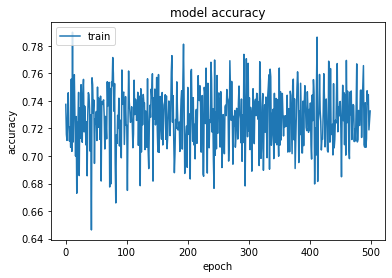

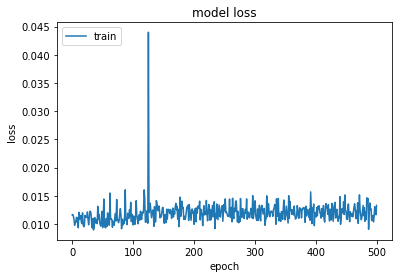

In [26]:
np.save('my_history.npy',history.history)

history2=np.load('my_history.npy',allow_pickle='TRUE').item()
print(history2.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# Save model
model_json = model.to_json()
with open("modelNew_14_09.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("modelNew_14_09.h5")

In [21]:
# Colorizer section 
images_to_color = []
for filename in os.listdir('../images/Images_version_5/Test/'):
    images_to_color.append(img_to_array(load_img('../images/Images_version_5/Test/'+filename)))

# convert color space, reshape img
images_to_color = np.array(images_to_color, dtype=float)
images_to_color = rgb2lab(1.0/255*images_to_color)[:,:,:,0]
images_to_color = images_to_color.reshape(images_to_color.shape+(1,))

# Test model with predict() function
output = model.predict(images_to_color)

# covert color value back from [-1,1] to [-128,128] which is Lab color spectrum
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))            # make empty 256x256 with 3 layers
    cur[:,:,0] = images_to_color[i][:,:,0]   # copy grayscale layer to new obj
    cur[:,:,1:] = output[i]                  # copy color layer to new obj
    # save img in directory
    imsave("../images/Images_version_5/Result/img_"+str(i)+".png", lab2rgb(cur))


C:\Users\setr7\miniconda3\lib\site-packages\skimage\color\colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\setr7\miniconda3\lib\site-packages\skimage\color\colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\setr7\miniconda3\lib\site-packages\skimage\color\colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 22 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to sup

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0